In [1]:
import warnings
warnings.simplefilter("ignore")
import tensorflow as tf
from tensorflow.math import reduce_min, reduce_max
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from pyDOE import lhs
from scipy.io import savemat
from scipy.fft import fftfreq, fftshift, fftn
import sys
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import *

2024-10-02 10:53:51.722996: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class NeuralNet:
    # Initialize the class
    def __init__(self, t_u, x_u, layers, kappa, lt, ut, acts=0):

        self.scale = tf.reduce_max(tf.abs(x_u)) / 2
        x_u2 = x_u / self.scale
        actv = [tf.tanh, tf.sin]

        self.t_u = t_u
        self.x_u = x_u2
        self.datatype = t_u.dtype

        self.lt = lt
        self.ut = ut

        self.layers = layers
        self.kappa = kappa

        # determine the activation function to use
        self.actv = actv[acts]

        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)

        # Create a list including all training variables
        self.train_variables = self.weights + self.biases
        # Key point: anything updates in train_variables will be
        #            automatically updated in the original tf.Variable

        # define the loss function
        self.loss0 = self.scale ** 2
        self.loss = []
        self.loss_0 = self.loss_NN()

        self.optimizer_Adam = tf.optimizers.Adam()

    '''
    Functions used to establish the initial neural network
    ===============================================================
    '''

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)

        for l in range(0, num_layers - 1):
            W = self.MPL_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=self.datatype))
            weights.append(W)
            biases.append(b)
        return weights, biases

    def MPL_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=self.datatype))

    def get_params(self):
        return (self.weights, self.biases)

    '''
    Functions used to building the physics-informed contrainst and loss
    ===============================================================
    '''

    def neural_net(self, X):
        weights = self.weights
        biases = self.biases

        num_layers = len(weights) + 1

        H = 2.0 * tf.math.divide(
                    tf.math.subtract(X, tf.transpose(self.lt)), 
                    tf.transpose(tf.math.subtract(self.ut, self.lt))) \
            - 1.0

        W = weights[0]
        b = biases[0]
        H = self.actv(tf.add(self.kappa * tf.matmul(H, W), b))

        for l in range(1, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    @tf.function
    # calculate the physics-informed loss function
    def loss_NN(self):
        self.x_pred = self.neural_net(self.t_u)
        loss = tf.reduce_mean(tf.square(self.x_u - self.x_pred))
        return loss

    '''
    Functions used to define ADAM optimizers
    ===============================================================
    '''

    # define the function to apply the ADAM optimizer
    def adam_function(self):
        @tf.function
        def f():
            # calculate the loss
            loss_norm = self.loss_NN()
            loss_value = loss_norm * self.loss0
            # store loss value so we can retrieve later
            tf.py_function(f.loss.append, inp=[loss_value], Tout=[])

            # print out iteration & loss
            f.iter.assign_add(1)

            str_iter = tf.strings.as_string([f.iter])
            str_loss = tf.strings.as_string([loss_value], precision=4, scientific=True)

            str_print = tf.strings.join(["Mode: Adam", "Iter: ", str_iter[0],
                                         ", loss: ", str_loss[0]])
            tf.cond(
                f.iter % 10 == 0,
                lambda: tf.print(str_print),
                lambda: tf.constant(True)  # return arbitrary for non-printing case
            )
            return loss_norm

        f.iter = tf.Variable(0)
        f.term = []
        f.loss = []
        return f

    def Adam_optimizer(self, nIter):
        varlist = self.train_variables
        func_adam = self.adam_function()
        for it in range(nIter):
            tf.keras.optimizers.Adam(func_adam, varlist)
            #self.optimizer_Adam.minimize(func_adam, varlist)
        return func_adam

    '''
    Functions used to define L-BFGS optimizers
    ===============================================================
    '''

    # A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    def Lbfgs_function(self, varlist):
        # obtain the shapes of all trainable parameters in the model
        shapes = tf.shape_n(varlist)
        n_tensors = len(shapes)

        # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
        # prepare required information first
        count = 0
        idx = []  # stitch indices
        part = []  # partition indices

        for i, shape in enumerate(shapes):
            n = np.prod(shape)
            idx.append(tf.reshape(tf.range(count, count + n, dtype=tf.int32), shape))
            part.extend([i] * n)
            count += n

        part = tf.constant(part)

        def assign_new_model_parameters(params_1d):
            # A function updating the model's parameters with a 1D tf.Tensor.
            # Sub-function under function of class not need to input self

            params = tf.dynamic_partition(params_1d, part, n_tensors)
            for i, (shape, param) in enumerate(zip(shapes, params)):
                varlist[i].assign(tf.reshape(param, shape))

        @tf.function
        def f(params_1d):
            # A function that can be used by tfp.optimizer.lbfgs_minimize.
            # This function is created by function_factory.
            # Sub-function under function of class not need to input self

            # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
            with tf.GradientTape() as tape:
                # update the parameters in the model
                # this step is critical for self-defined function for L-BFGS
                assign_new_model_parameters(params_1d)
                # calculate the loss
                loss_norm = self.loss_NN()
                loss_value = loss_norm * self.loss0

            # calculate gradients and convert to 1D tf.Tensor
            grads = tape.gradient(loss_norm, varlist)
            grads = tf.dynamic_stitch(idx, grads)

            # store loss value so we can retrieve later
            tf.py_function(f.loss.append, inp=[loss_value], Tout=[])

            # print out iteration & loss
            f.iter.assign_add(1)

            str_iter = tf.strings.as_string([f.iter])
            str_loss = tf.strings.as_string([loss_value], precision=4, scientific=True)

            str_print = tf.strings.join(["Mode: LBFGS", "Iter: ", str_iter[0],
                                         ", loss: ", str_loss[0]])
            tf.cond(
                f.iter % 3000 == 0,
                lambda: tf.print(str_print),
                lambda: tf.constant(True)  # return arbitrary for non-printing case
            )

            return loss_value, grads

        # store these information as members so we can use them outside the scope
        f.iter = tf.Variable(0)
        f.idx = idx
        f.part = part
        f.shapes = shapes
        f.assign_new_model_parameters = assign_new_model_parameters
        f.loss = []

        return f

    # define the function to apply the L-BFGS optimizer
    def Lbfgs_optimizer(self, nIter, varlist):

        func = self.Lbfgs_function(varlist)

        # convert initial model parameters to a 1D tf.Tensor
        init_params = tf.dynamic_stitch(func.idx, varlist)

        max_nIter = tf.cast(nIter / 3, dtype=tf.int32)

        # train the model with L-BFGS solver
        results = tfp.optimizer.lbfgs_minimize(
            value_and_gradients_function=func, initial_position=init_params,
            tolerance=1e-11, max_iterations=max_nIter)

        # after training, the final optimized parameters are still in results.position
        # so we have to manually put them back to the model
        func.assign_new_model_parameters(results.position)

        return func

    '''
    Function used for training the model
    ===============================================================
    '''

    def train(self, nIter, idxOpt):
        if idxOpt == 1:
            # mode 1: running the Adam optimization
            func_adam = self.Adam_optimizer(nIter)
            self.loss += func_adam.loss
        elif idxOpt == 2:
            # mode 2: running the Lbfgs optimization
            func_bfgs = self.Lbfgs_optimizer(nIter, self.train_variables)
            self.loss += func_bfgs.loss

    # @tf.function
    def predict(self, t):
        x_p = self.neural_net(t) * self.scale
        return x_p

    


In [48]:
class MultistageNeuralNetwork:
    '''MultistageNeuralNetwork is the multi-stage model used for predicting
    high-dimensional function outputs through regression. The network takes as parameters the input dataset,
    an n-dimensional square tensor of grid points, a list of labels corresponding to function outputs at each grid point,
    a number of stages for the MSNN, a number of hidden layers for each stage, and a number of hidden nodes in each
    hidden layer of each stage of the MSNN'''
    def __init__(self, train_data, train_y, num_stages, num_hidden_layers, num_hidden_nodes):
        # metadata for MSNN setup
        self.dim = len(train_data.shape)
        self.train_data = train_data
        self.train_y = train_y
        self.stages = [None] * num_stages
        self.layers = [self.dim] + ([num_hidden_nodes] * num_hidden_layers) + [1]
        self.lt = [reduce_min(self.input[:, i]) for i in range(self.input.shape[-1])]
        self.ut = [reduce_max(self.input[:, i]) for i in range(self.input.shape[-1])]


    ## TODO
    def sample(self, dataset, labels, sample_step):
        # flattened_data = dataset.numpy().flatten()
        # sample_data = flattened_data[::sample_step]
        # sample_tf = tf.convert_to_tensor(sample_data, tf.float64)
        # new_shape = [dataset.shape[0] // sample_step] * self.dim
        # sample_tf = tf.reshape(sample_tf, new_shape)
        # sample_labels = labels[::sample_step]
        # return sample_tf, sample_labels
        pass
    

    def train(self, stage):
        act = 0 if stage == 1 else 1
        self.stages[stage - 1] = model = NeuralNet(self.data, self.labels, self.layers, kappa=1, lt=self.lt, ut=self.ut, acts=act)
        model.train(3000, 1)     # mode 1 use Adam
        model.train(10000, 2)    # mode 2 use L-bfgs

    def predict(self, stage, data):
        self.stages[stage - 1].predict(data)
    
    # TODO: fix for higher dimensions than just 2 by working on reshape function
    def compute_kappa(self, stage):
        sample = self.sample(self.train_data, self.train_y, 5)
        N_train = len(sample[0])
        residue = self.train_y - sum(self.stages[i].predict(sample) for i in range(stage-1))
        g = residue.numpy()

        GG = g.reshape(N_train, N_train)
        print(GG)
        G = fftn(GG)
        G_shifted = fftshift(G)
        print(G_shifted.shape)

        N = len(G)
        # Total time range
        total_time_range = 2  # from -1 to 1

        # Calculate the sample rate
        sample_rate = N / total_time_range

        # # Perform FFT
        half_N = N // 2
        T = 1.0 / sample_rate
        G_pos = G_shifted[half_N:, half_N:]
        freq_x = fftshift(fftfreq(GG.shape[1], d=T))
        freq_y = fftshift(fftfreq(GG.shape[0], d=T))

        freq_x_pos = freq_x[half_N:]
        freq_y_pos = freq_y[half_N:]

        # Identify the dominant frequency
        magnitude_spectrum = np.abs(G_pos)
        max_idx = np.unravel_index(np.argmax(magnitude_spectrum), magnitude_spectrum.shape)
        dominant_freq_x = freq_x_pos[max_idx[1]]
        dominant_freq_y = freq_y_pos[max_idx[0]]
        magnitude = magnitude_spectrum[max_idx] / (N * N) # normalize magnitude
        dominant_freq = max(dominant_freq_x, dominant_freq_y)
        print(f"Stage {stage} Kappa Calculation")
        print(f"Sample rate: {sample_rate} Hz")
        print(f"Dominant Frequency: {dominant_freq} Hz")
        print(f"Magnitude: {magnitude}")
        kappa_f =  2 * np.pi * dominant_freq
        return kappa_f
        


In [ ]:
dataset = tf.zeros([20, 20])
labels = [0] * 100 ** 3
test_net = MultistageNeuralNetwork(dataset, labels, 4, 3, 20)


In [19]:
np.random.seed(234)
tf.random.set_seed(234)

def fun_test(t):
    # customize the function by the user
    x = (t ** 3) / (0.01 + t ** 4) # example 2
    #x = tf.math.log(t+2) * tf.cos(2*t + t**3)   # example 1
    # x = tf.sin(2*t+1) + 0.2*tf.exp(1.3*t)  # example 2
    return x

def create_ds(dims, lo, hi, N):
    dimensions = [np.linspace(lo, hi, N)] * dims
    mesh = np.meshgrid(*dimensions, indexing='xy')
    mesh_points = np.stack([m.flatten() for m in mesh], axis=-1)
    mesh_tf = tf.cast(mesh_points, dtype=tf.float64)
    return mesh_tf

def fun_test2d(t):
    x = (np.sin(2 * t[:, 0] + 1) - 0.5 * t[:, 0])*(1 - t[:, 1] ** 2)
    return x

def nd_fun(t):
    if t.shape[-1] <= 1: return t
    x = [tf.math.reduce_sum(t, axis=-1)]
    return x

def poisson(t, dims):
    # equation is:
    # (sum of partials of x) = partials of (1 - l2 norm(x)^2)*(sum_{i=1}^{d-1}c_i * sin(x_i + cos(x_{i+1} + x_{i+1}cos(x_i))))
    pass

In [38]:
# Train for each dimension size over 4 stages of MSNN
# for dim in range(1, 3):
dim = 1
N_train = 1501
N_eval = 8000
N_train2 = 21
N_eval2 = 200
t_train = create_ds(dim, -1.02, 1.02, N_train)
x_train = tf.reshape(nd_fun(t_train), [len(t_train)], 1)
t_eval = create_ds(dim, -1.02, 1.02, N_eval)
x_eval = tf.reshape(nd_fun(t_eval), [len(t_eval)], 1)

lt = [reduce_min(t_train[:, i]) for i in range(t_train.shape[-1])]
ut = [reduce_max(t_train[:, i]) for i in range(t_train.shape[-1])]
lt = tf.convert_to_tensor(lt)
ut = tf.convert_to_tensor(ut)

# stage 1
layers = [dim, 30, 30, 30, 1]
kappa1 = 1
model1 = NeuralNet(t_train, x_train, layers, kappa1, lt, ut, acts=0)
model1.train(3000, 1)     # mode 1 use Adam
model1.train(10000, 2)    # mode 2 use L-bfgs
x_train2 = x_train - model1.predict(t_train)
x_pred1 = model1.predict(t_eval)

In [ ]:
kappa2 = fft_analysis(x_train2, N_train, dim=1)
print(kappa2)

In [34]:
dim = 2
N_test = 20000
x_radius = 1

# Generate random values for all {dim} input variables, x, and their corresponding output value, u
c = np.random.randn(1, dim - 1)
const_2 = 1
def load_data_TwoBody_Poisson(d, N_test, x_radius=1):
    def func_u(x):
        temp =  x_radius**2 - np.sum(x**2, 1)
        temp2 = c * np.sin(x[:, :-1] + const_2 * np.cos(x[:, 1:]) + x[:, 1:] * np.cos(x[:, :-1]))
        temp2 = np.sum(temp2, 1)
        return temp * temp2

    x = np.random.randn(N_test, d)
    r = np.random.rand(N_test, 1) * x_radius
    x = x / np.linalg.norm(x, axis=1, keepdims=True) * r
    u = func_u(x)
    return x, u

x, u = load_data_TwoBody_Poisson(dim, N_test)
x = tf.convert_to_tensor(x, dtype=tf.float64)
u = tf.convert_to_tensor(u, dtype=tf.float64)

In [38]:
N_f = 1000 # Number of collocation points

xf = np.random.randn(N_f, dim)
rf = np.random.rand(N_f, 1) * x_radius
xf = xf / np.linalg.norm(xf, axis=1, keepdims=True) * rf
x = xf

u1 = x_radius**2 - np.sum(x**2, 1, keepdims=True)
du1_dx = -2 * x
d2u1_dx2 = -2

x1, x2 = x[:, :-1], x[:, 1:]
coeffs = c
u2 = coeffs * np.sin(x1 + const_2 * np.cos(x2) + x2 * np.cos(x1))
u2 = np.sum(u2, 1, keepdims=True)
du2_dx_part1 = coeffs * np.cos(x1 + const_2 * np.cos(x2) + x2 * np.cos(x1)) * \
        (1 - x2 * np.sin(x1))
du2_dx_part2 = coeffs * np.cos(x1 + const_2 * np.cos(x2) + x2 * np.cos(x1)) * \
        (-const_2 * np.sin(x2) + np.cos(x1))
du2_dx = np.zeros((N_f, dim))
du2_dx[:, :-1] += du2_dx_part1
du2_dx[:, 1:] += du2_dx_part2
d2u2_dx2_part1 = -coeffs * np.sin(x1 + const_2 * np.cos(x2) + x2 * np.cos(x1)) * (1 - x2 * np.sin(x1))**2 + \
        coeffs * np.cos(x1 + const_2 * np.cos(x2) + x2 * np.cos(x1)) * (- x2 * np.cos(x1))
d2u2_dx2_part2 = -coeffs * np.sin(x1 + const_2 * np.cos(x2) + x2 * np.cos(x1)) * (-const_2 * np.sin(x2) + np.cos(x1))**2 + \
        coeffs * np.cos(x1 + const_2 * np.cos(x2) + x2 * np.cos(x1)) * (-const_2 * np.cos(x2))
d2u2_dx2 = np.zeros((N_f, dim))
d2u2_dx2[:, :-1] += d2u2_dx2_part1
d2u2_dx2[:, 1:] += d2u2_dx2_part2
ff = u1 * d2u2_dx2 + 2 * du1_dx * du2_dx + u2 * d2u1_dx2
ff = np.sum(ff, 1)
u = (u1 * u2).reshape(-1)
ff = ff + np.sin(u)

xf = tf.convert_to_tensor(xf, dtype=tf.float64) # 
ff = tf.convert_to_tensor(ff, dtype=tf.float64)        

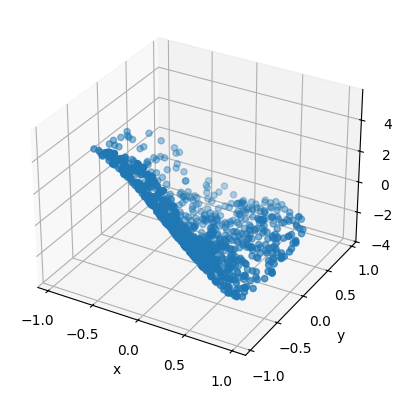

In [39]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xf[:, 0], xf[:, 1], ff)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')

plt.show()
